I'm curious what the HOD parameters I recover from SHAM (and UM) in a cosmological context. Similarly, do the Assembly bias values I recover make sense? 

In [47]:
from matplotlib import pyplot as plt
%matplotlib inline

In [48]:
import numpy as np
from os import path
import h5py
import astropy
from scipy.special import erf
from halotools.mock_observables import hod_from_mock
from halotools.utils import broadcast_host_halo_property, add_halo_hostid

In [49]:
from pearce.mocks.kittens import TrainingBox

In [50]:
um_dir = '/u/ki/swmclau2/des/aemulus_mock_catalogs/'

In [51]:
cen_hod = np.load(path.join(um_dir,'um_cen_hod.npy'))
sat_hod = np.load(path.join(um_dir,'um_sat_hod.npy'))
tot_hod = np.load(path.join(um_dir,'um_hod.npy'))

In [52]:
mass_func = np.load(path.join(um_dir, 'mass_function.npy'))

In [53]:
haloprop_bins = np.logspace(10,16, 60)
mbc = (haloprop_bins[1:]+haloprop_bins[:-1])/2.0

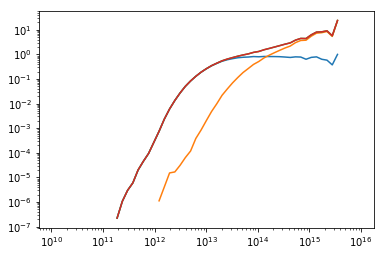

In [54]:
plt.plot(mbc, cen_hod)
plt.plot(mbc, sat_hod)
plt.plot(mbc, cen_hod+sat_hod)
plt.plot(mbc, tot_hod)
plt.loglog();

In [55]:
def ZhengCenHOD(mass, param_dict):
    
    logM = np.log10(mass)
    mean_ncen = 0.5*(1.0 + erf(
        (logM - param_dict['logMmin']) / param_dict['sigma_logM']))

    return mean_ncen

def ZhengSatHOD(mass, param_dict, mean_ncen = None):
    M0 = 10.**param_dict['logM0']
    M1 = 10.**param_dict['logM1']

    mean_nsat = np.zeros_like(mass)

    idx_nonzero = np.where(mass - M0 > 0)[0]
    
    mean_nsat[idx_nonzero] = ((mass[idx_nonzero] - M0)/M1)**param_dict['alpha']

    # If a central occupation model was passed to the constructor,
    # multiply mean_nsat by an overall factor of mean_ncen
    if mean_ncen is not None:
        # compatible with AB models
        mean_nsat *= mean_ncen

    return mean_nsat

def ZhengHOD(mass, param_dict):
    mean_ncen = ZhengCenHOD(mass, param_dict)
    mean_nsat = ZhengSatHOD(mass, param_dict, mean_ncen)
    return mean_ncen, mean_nsat

In [56]:
def calc_nd(mass,param_dict, mass_func):
    cen_hod, sat_hod = ZhengHOD(mass, param_dict)
    hod = cen_hod+sat_hod
    return np.dot(mass_func, hod)/(1000.0**3)

from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, mass, mass_func):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (calc_nd(mass, hod_params, mass_func) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12,15), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [57]:
with h5py.File('/u/ki/swmclau2/des/PearceMCMC/UniverseMachine_wp_ds_rmin_0.5_HSAB.hdf5', 'r') as f:
    hod_pnames =  f.attrs['param_names'][7:-1]
    chain = f['chain'][:, 7:-1]

In [58]:
param_dict = dict(zip(hod_pnames, chain[0]))

In [59]:
add_logMmin(param_dict, mbc, mass_func)

In [60]:
cat = TrainingBox(0)
cat.load(1.0, HOD='zheng07')

In [61]:
def add_logMmin2(cat, params, nd):
    def func(logMmin, hod_params):
        params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(params, min_ptcl=20) - nd)**2

    res = minimize_scalar(func, bounds = (12,16), args = (params,), options = {'maxiter':100}, method = 'Bounded')

     # assuming this doens't fail
    #print 'logMmin', res.x
    params['logMmin'] = res.x


In [62]:
np.sum(mass_func*cen_hod)/(1000.0**3)

0.000418701

**********


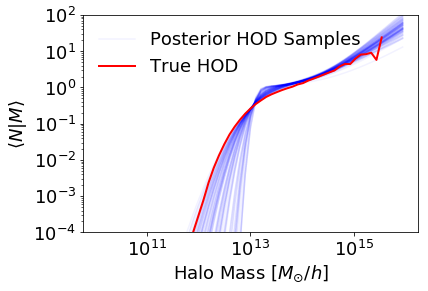

In [63]:
N = 100
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(6,4))
idxs = np.random.choice(chain.shape[0], size=N, replace=False)

for ino, i in enumerate(idxs):
    param_dict = dict(zip(hod_pnames, chain[i]))
    add_logMmin(param_dict, mbc, mass_func)
    c, s = ZhengHOD(mbc, param_dict)
    if ino == 0:
        plt.plot(mbc, c+s, alpha = 0.05, color = 'b', label = 'Posterior HOD Samples')

    else:
        plt.plot(mbc, c+s, alpha = 0.05, color = 'b')
    
plt.plot(mbc, tot_hod, color = 'r', lw =2, label = 'True HOD')
print '*'*10
#add_logMmin(param)
#c,s = ZhengHOD(mbc, true_hod_params)
#plt.plot(mbc, c+s, color ='k')
plt.loglog();
plt.legend(loc=2, frameon=False)
#plt.title('HOD Posterior Samples')
plt.ylim([1e-4, 1e2])
plt.xlabel(r'Halo Mass [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N | M \rangle$')

**********


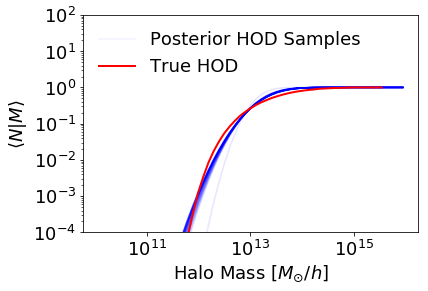

In [27]:
N = 100
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(6,4))
idxs = np.random.choice(chain.shape[0], size=N, replace=False)

for ino, i in enumerate(idxs):
    param_dict = dict(zip(hod_pnames, chain[i]))
    add_logMmin(param_dict, mbc, mass_func)
    c, s = ZhengHOD(mbc, param_dict)
    if ino == 0:
        plt.plot(mbc, c, alpha = 0.05, color = 'b', label = 'Posterior HOD Samples')

    else:
        plt.plot(mbc, c, alpha = 0.05, color = 'b')
    
plt.plot(mbc, cen_hod, color = 'r', lw =2, label = 'True HOD')
print '*'*10
#add_logMmin(param)
#c,s = ZhengHOD(mbc, true_hod_params)
#plt.plot(mbc, c+s, color ='k')
plt.loglog();
plt.legend(loc=2, frameon=False)
#plt.title('HOD Posterior Samples')
plt.ylim([1e-4, 1e2])
plt.xlabel(r'Halo Mass [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N | M \rangle$')

**********


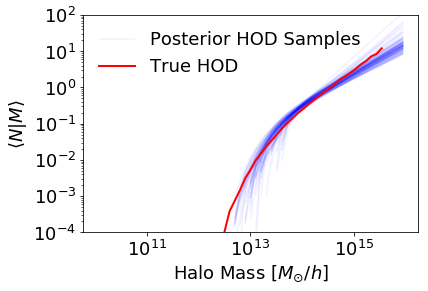

In [28]:
N = 100
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(6,4))
idxs = np.random.choice(chain.shape[0], size=N, replace=False)

for ino, i in enumerate(idxs):
    param_dict = dict(zip(hod_pnames, chain[i]))
    add_logMmin(param_dict, mbc, mass_func)
    c, s = ZhengHOD(mbc, param_dict)
    if ino == 0:
        plt.plot(mbc, s, alpha = 0.05, color = 'b', label = 'Posterior HOD Samples')

    else:
        plt.plot(mbc, s, alpha = 0.05, color = 'b')
    
plt.plot(mbc, sat_hod, color = 'r', lw =2, label = 'True HOD')
print '*'*10
#add_logMmin(param)
#c,s = ZhengHOD(mbc, true_hod_params)
#plt.plot(mbc, c+s, color ='k')
plt.loglog();
plt.legend(loc=2, frameon=False)
#plt.title('HOD Posterior Samples')
plt.ylim([1e-4, 1e2])
plt.xlabel(r'Halo Mass [$M_{\odot}/h$]')
plt.ylabel(r'$\langle N | M \rangle$')

In [39]:
catalog = np.load(path.join(um_dir,'hod_catalog3.npy'), allow_pickle=True )

In [40]:
mdpl2_sat_mask = np.ones_like(catalog['gal_type'], dtype=bool)# == 'satellites'

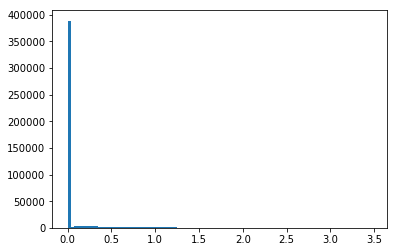

In [41]:
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance'], bins = 100);

In [42]:
gal_table = cat.model.mock.galaxy_table
sat_mask= np.ones_like(gal_table['gal_type'], dtype = bool)

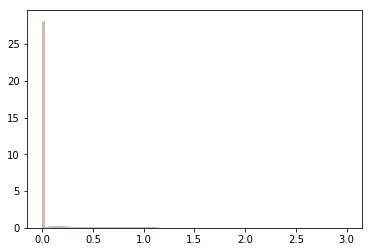

In [43]:
bins = np.linspace(0, 3, 100)
plt.hist(gal_table[sat_mask]['host_centric_distance'], bins = bins, alpha = 0.3, normed=True);
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance'], bins = bins, alpha = 0.3, normed=True);


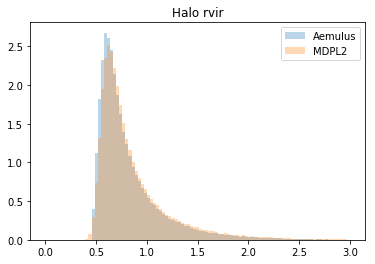

In [44]:
bins = np.linspace(0,3, 100)
plt.hist(gal_table[sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(1.0*catalog[mdpl2_sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.title('Halo rvir')

In [45]:
mass_bins = np.logspace(12, 16, 4.0/0.1+1)
rvir_perc = np.zeros((len(mass_bins)-1,))
for i, (mb_low, mb_high) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
    mass_cut = np.logical_and(mb_low < catalog['halo_mvir'], mb_high > catalog['halo_mvir'])
    cat_at_m = catalog[mass_cut]
    if len(cat_at_m) == 0:
        continue
    rvir_perc[i] = np.percentile(cat_at_m['halo_rvir'], [50])[0]

In [46]:
mass_bins = np.logspace(12, 16, 4.0/0.1+1)
rvir_perc_aemulus = np.zeros((len(mass_bins)-1,))
for i, (mb_low, mb_high) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
    mass_cut = np.logical_and(mb_low < gal_table['halo_mvir'], mb_high > gal_table['halo_mvir'])
    cat_at_m = gal_table[mass_cut]
    if len(cat_at_m) == 0:
        continue
    rvir_perc_aemulus[i] = np.percentile(cat_at_m['halo_rvir'], [50])[0]

(1.0, 1.2)

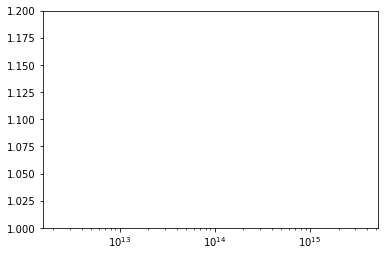

In [47]:
mbc = (mass_bins[1:]+mass_bins[:-1])/2.0
#plt.plot(mbc, rvir_perc)#, yerr = (rvir_perc[:,2]-rvir_perc[:,0])/2 )
plt.plot(mbc, rvir_perc_aemulus/rvir_perc, label ='Aemulus/mdpl2')
plt.xscale('log')
plt.ylim([1.0, 1.2])

In [48]:
import astropy.constants as const
from astropy import units as u
Om0 = 0.341
C = (const.G*const.M_sun/((100*u.km/u.s/u.Mpc)**2))
new_rvir = np.cbrt( C*(gal_table['halo_mvir']/(100*Om0))).to('Mpc').value

In [49]:
new_rvir/gal_table['halo_rvir']#)#, bins = np.linspace(0.9,1.1,11));

0.9995536
0.9995576
0.9995439
0.9995488
0.9995505
0.9995489
0.999551
0.99955285
0.9995439
0.99954665
0.99955225


In [50]:
cat

trainingbox
-------------------------
Halo finder:	 rockstar
Version name:	most_recent_00
Cosmology:
FlatwCDM(H0=63.4 km / (Mpc s), Om0=0.341, w0=-0.817, Tcmb0=0 K, Neff=2.92, m_nu=None, Ob0=0.0565)
Redshifts:	[3.0, 2.003003003003003, 1.0, 0.8499984275013364, 0.7000008500004251, 0.550000697500314, 0.399999440000224, 0.25, 0.09999989000001097, 0.0]
-------------------------
Location:	/nfs/slac/g/ki/ki18/des/swmclau2/NewAemulusBoxes/Box000/halos/m200b/
Lbox:	1050.0
Particle Mass:	39876900000.000000
Columns to Keep:
{'halo_upid': (14, 'i8'), 'halo_vx': (11, 'f4'), 'halo_y': (9, 'f4'), 'halo_x': (8, 'f4'), 'halo_z': (10, 'f4'), 'halo_vy': (12, 'f4'), 'halo_vz': (13, 'f4'), 'halo_rs': (6, 'f4'), 'halo_rvir': (5, 'f4'), 'halo_mvir': (2, 'f4'), 'halo_id': (0, 'i8')}

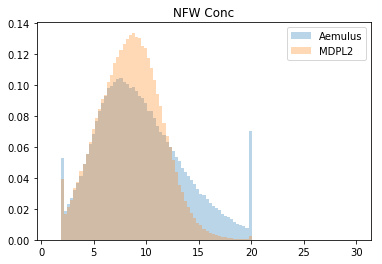

In [51]:
bins = np.linspace(1, 30, 100)
plt.hist(gal_table[sat_mask]['conc_NFWmodel'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(1.0*catalog[mdpl2_sat_mask]['conc_NFWmodel'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.title('NFW Conc')

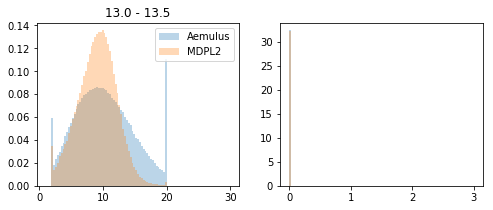

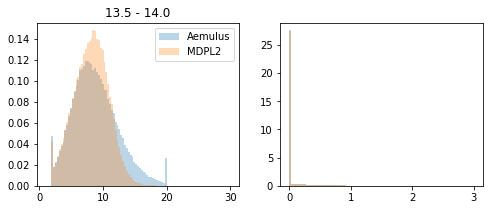

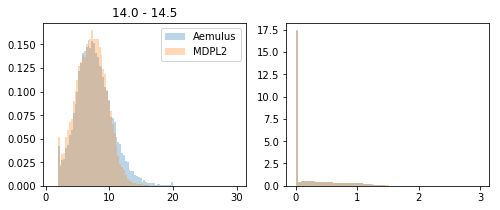

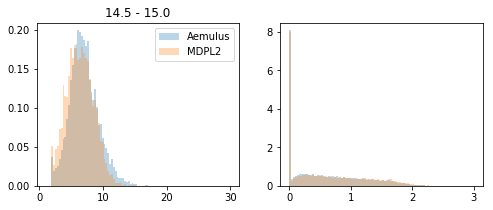

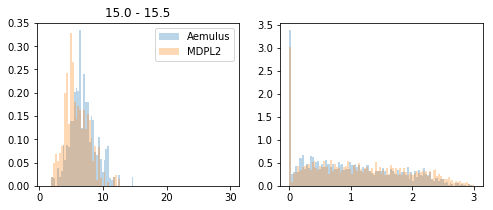

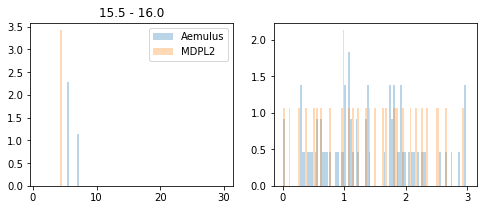

In [52]:
cbins = np.linspace(1, 30, 100)
rbins = np.linspace(0, 3, 100)

haloprop_bins = np.logspace(13,16,7)

for i,(mbl, mbh) in enumerate(zip(haloprop_bins[:-1], haloprop_bins[1:])):
    fig = plt.figure(figsize=(8,3))
    mass_cut = np.logical_and(mbl<gal_table['halo_mvir'], gal_table['halo_mvir']<mbh)
    mask = np.logical_and(mass_cut, sat_mask)
    plt.subplot(121)
    plt.hist(gal_table[mask]['conc_NFWmodel'], bins = cbins, alpha = 0.3, normed=True, label = 'Aemulus');
    
    mass_cut = np.logical_and(mbl<catalog['halo_mvir'], catalog['halo_mvir']<mbh)
    mask2 = np.logical_and(mass_cut, mdpl2_sat_mask)
    plt.hist(1.0*catalog[mask2]['conc_NFWmodel'], bins = cbins, alpha = 0.3, normed=True, label = 'MDPL2');
    plt.title('%0.1f - %0.1f'%(np.log10(mbl),np.log10(mbh)))
    plt.legend(loc='best')
    plt.subplot(122)
    plt.hist(gal_table[mask]['host_centric_distance'], bins = rbins, alpha = 0.3, normed=True);
    plt.hist(catalog[mask2]['host_centric_distance'], bins = rbins, alpha = 0.3, normed=True);

    plt.show()

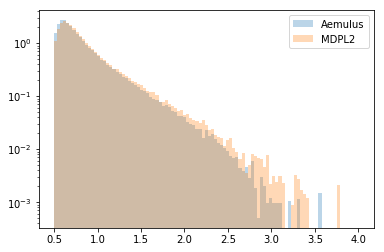

In [53]:
bins = np.linspace(0.5, 4, 100)
plt.hist(gal_table[sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(catalog[mdpl2_sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.yscale('log')